# Modelo probabilista (apartado b)
## Clasificación por día de la semana (laboral o fin semana/festivo)

### Lectura de los datos

In [2]:
import pandas as pd

df_train = pd.read_parquet("../data/train.parquet")
df_test = pd.read_parquet("../data/test.parquet")

### Exploración inicial

In [10]:
df_train["weekday"].unique()

array(['Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed'], dtype=object)

Distribución de los distintos días de la semana

In [6]:
df_train["weekday"].value_counts()

weekday
Mon    20663
Thu    19350
Sun    18560
Fri    18504
Tue    16325
Wed    15185
Sat    15146
Name: count, dtype: int64

Distribución de los días festivos

In [9]:
df_train[df_train["is_holiday"] == True]["weekday"].value_counts()

weekday
Wed    2703
Mon    1975
Fri    1597
Name: count, dtype: int64

### Preparación de los datos

Dos clases:
- 0 -> día laboral (L, M, X, J, V)
- 1 -> fin de semana o día festivo

Generación de las etiquetas:

In [3]:
import numpy as np

# df['is_holiday']: columna booleana
# df['weekday']: columna de strings ('Thu', 'Fri', etc.)

# Definir qué días son fin de semana
weekend_days = ['Sat', 'Sun']

# Construir y: 0 = día laboral, 1 = fin de semana o festivo
y_train = np.where(
    (df_train['is_holiday']) | (df_train['weekday'].isin(['Sat', 'Sun'])),
    1,
    0
)

y_test = np.where(
    (df_test['is_holiday']) | (df_test['weekday'].isin(['Sat', 'Sun'])),
    1,
    0
)

Preprocesamiento y construcción del conjunto de características:

- NumPyro espera que las entradas sean numéricas y no maneja nulos
- Eliminar fechas: timestamp, weekday, is_holiday
- Eliminar IDs: icao, callsign
- Codificar categóricas
- Normalizar numéricas


In [20]:
df_train.columns

Index(['takeoff_time', 'timestamp', 'icao', 'callsign', 'holding_point',
       'runway', 'operator', 'turbulence_category', 'last_min_takeoffs',
       'last_min_landings', 'last_event_turb_cat',
       'time_since_last_event_seconds', 'time_before_holding_point',
       'time_at_holding_point', 'hour', 'weekday', 'is_holiday', 'Z1', 'KA6',
       'KA8', 'K3', 'K2', 'K1', 'Y1', 'Y2', 'Y3', 'Y7', 'Z6', 'Z4', 'Z2', 'Z3',
       'LF', 'L1', 'LA', 'LB', 'LC', 'LD', 'LE', '36R_18L', '32R_14L',
       '36L_18R', '32L_14R', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'dew_point_2m (°C)', 'precipitation (mm)', 'snowfall (cm)',
       'weather_code (wmo code)', 'surface_pressure (hPa)', 'cloud_cover (%)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'is_day ()', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)',
       'wind_direction_100m (°)', 'soil_moisture_0_to_7cm (m³/m³)',
       'soil_temperature_100_to_255cm (°C)',
       'soil_moist

In [4]:
# Booleanas True/False a enteros 1/0
bool_cols = ['Z1', 'KA6', 'KA8', 'K3', 'K2', 'K1', 'Y1', 'Y2', 'Y3', 'Y7', 'Z6', 'Z4', 
             'Z2', 'Z3', 'LF', 'L1', 'LA', 'LB', 'LC', 'LD', 'LE', '36R_18L', '32R_14L', '36L_18R', '32L_14R']

df_train[bool_cols] = df_train[bool_cols].astype(int)
df_test[bool_cols] = df_test[bool_cols].astype(int)

In [5]:
# --- Codificamos "operator" reduciendo el número de aerolíneas ---

# Paso 1: Encontrar las 7 aerolíneas más frecuentes en train
top_operators = df_train['operator'].value_counts().nlargest(7).index.tolist()

# Paso 2: Crear nueva columna, donde:
# - Si el operator está en top_operators → lo dejamos igual
# - Si no → lo reemplazamos por "other"

def map_operator(op):
    return op if op in top_operators else 'other'

df_train['operator_grouped'] = df_train['operator'].apply(map_operator)
df_test['operator_grouped'] = df_test['operator'].apply(map_operator)

In [6]:
# --- OneHot Encoding ---
ohe_cols = ['operator_grouped', 'runway', 'holding_point', 'turbulence_category', 'last_event_turb_cat']

df_train = pd.get_dummies(df_train, columns=ohe_cols, drop_first=False, dtype="int")
df_test = pd.get_dummies(df_test, columns=ohe_cols, drop_first=False, dtype="int")

In [7]:
# --- Normalizamos columnas numéricas ---

from sklearn.preprocessing import StandardScaler

# Lista de columnas numéricas
numeric_columns = [
    'takeoff_time', 'last_min_takeoffs', 'last_min_landings', 'time_since_last_event_seconds', 
    'time_before_holding_point', 'time_at_holding_point', 'hour',
    'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 
    'precipitation (mm)', 'snowfall (cm)', 'weather_code (wmo code)', 
    'surface_pressure (hPa)', 'cloud_cover (%)', 'cloud_cover_low (%)', 
    'cloud_cover_mid (%)', 'cloud_cover_high (%)', 'is_day ()', 'wind_speed_10m (km/h)', 
    'wind_direction_10m (°)', 'wind_direction_100m (°)', 'soil_moisture_0_to_7cm (m³/m³)', 
    'soil_temperature_100_to_255cm (°C)', 'soil_moisture_100_to_255cm (m³/m³)', 
    'et0_fao_evapotranspiration (mm)'
]

# Creamos el scaler
scaler = StandardScaler()

# Aplicamos la normalización
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])

In [8]:
# --- Eliminamos columnas innecesarias ---
cols_to_exclude = ["timestamp", "weekday", "is_holiday", "icao", "callsign", "operator"]

df_train = df_train.drop(columns=cols_to_exclude)
df_test = df_test.drop(columns=cols_to_exclude)

In [9]:
pd.set_option('display.max_columns', None)
df_train.head()

,takeoff_time,last_min_takeoffs,last_min_landings,time_since_last_event_seconds,time_before_holding_point,time_at_holding_point,hour,Z1,KA6,KA8,K3,K2,K1,Y1,Y2,Y3,Y7,Z6,Z4,Z2,Z3,LF,L1,LA,LB,LC,LD,LE,36R_18L,32R_14L,36L_18R,32L_14R,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),precipitation (mm),snowfall (cm),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),is_day (),wind_speed_10m (km/h),wind_direction_10m (°),wind_direction_100m (°),soil_moisture_0_to_7cm (m³/m³),soil_temperature_100_to_255cm (°C),soil_moisture_100_to_255cm (m³/m³),et0_fao_evapotranspiration (mm),operator_grouped_AEA,operator_grouped_ANE,operator_grouped_IBB,operator_grouped_IBE,operator_grouped_IBS,operator_grouped_QTR,operator_grouped_RYR,operator_grouped_other,runway_32L/14R,runway_32R/14L,runway_36L/18R,runway_36R/18L,holding_point_K1,holding_point_K2,holding_point_K3,holding_point_LA,holding_point_LB,holding_point_LC,holding_point_LD,holding_point_LE,holding_point_Y1,holding_point_Y2,holding_point_Y3,holding_point_Z1,holding_point_Z2,holding_point_Z3,holding_point_Z4,holding_point_Z6,turbulence_category_Heavy,turbulence_category_High performance,turbulence_category_High vortex aircraft,turbulence_category_Light,turbulence_category_Medium 1,turbulence_category_Medium 2,last_event_turb_cat_Ground obstruction,last_event_turb_cat_Heavy,last_event_turb_cat_High performance,last_event_turb_cat_High vortex aircraft,last_event_turb_cat_Light,last_event_turb_cat_Medium 1,last_event_turb_cat_Medium 2
0,0.893687,-1.399119,0.563255,1.813737,-0.25737,-0.535211,-1.814484,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.206903,1.169886,1.075527,-0.144296,0.0,-0.359307,-0.246196,-1.245264,-0.69563,-0.542309,-0.850611,-1.393543,-0.133123,-1.231392,-0.857486,2.285364,1.199723,2.948543,-0.931666,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0.893687,-1.399119,0.563255,1.813737,-0.25737,-0.535211,-1.814484,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.206903,1.169886,1.075527,-0.144296,0.0,-0.359307,-0.246196,-1.245264,-0.69563,-0.542309,-0.850611,-1.393543,-0.133123,-1.231392,-0.857486,2.285364,1.199723,2.948543,-0.931666,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0.820915,-1.399119,0.563255,1.853526,-0.25737,-0.428569,-1.814484,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.206903,1.169886,1.075527,-0.144296,0.0,-0.359307,-0.246196,-1.245264,-0.69563,-0.542309,-0.850611,-1.393543,-0.133123,-1.231392,-0.857486,2.285364,1.199723,2.948543,-0.931666,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,0.811818,-1.399119,0.563255,1.858500,-0.25737,-0.415239,-1.814484,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.206903,1.169886,1.075527,-0.144296,0.0,-0.359307,-0.246196,-1.245264,-0.69563,-0.542309,-0.850611,-1.393543,-0.133123,-1.231392,-0.857486,2.285364,1.199723,2.948543,-0.931666,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0.811818,-1.399119,0.563255,1.858500,-0.25737,-0.415239,-1.814484,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.206903,1.169886,1.075527,-0.144296,0.0,-0.359307,-0.246196,-1.245264,-0.69563,-0.542309,-0.850611,-1.393543,-0.133123,-1.231392,-0.857486,2.285364,1.199723,2.948543,-0.931666,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Arreglamos desajuste en el número de columnas entre train y test

In [10]:
print(len(df_train.columns), len(df_test.columns))

92 90


In [11]:
# Columnas en train y no en test
for col in df_train.columns:
    if col not in df_test.columns:
        print(col)
        df_test[col] = 0

holding_point_LD
holding_point_Z6
last_event_turb_cat_Ground obstruction


In [12]:
# Columnas en test y no en train
for col in df_test.columns:
    if col not in df_train.columns:
        print(col)
        df_train[col] = 0

last_event_turb_cat_Reserved


In [13]:
print(len(df_train.columns), len(df_test.columns))

93 93


Creamos X_train y X_test como matrices de NumPy

In [14]:
X_train = df_train.to_numpy()
X_test = df_test.to_numpy()

In [15]:
X_train.shape, X_test.shape

((123733, 93), (27791, 93))

### Definición del modelo

Modelo de regresión logística. Utiliza una distribución Bernoulli para modelar las probabilidades de pertenencia a una clase. Para el entrenamiento ejecuta un muestreo MCMC usando el No-U-Turn Sampler (NUTS) para inferir los parámetros del modelo.


In [16]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

# Definimos el modelo en NumPyro
def model(X, y=None):
    # Definir los parámetros del modelo (coeficientes de regresión)
    n_features = X.shape[1]  # Número de características (columnas en X)
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros(n_features), jnp.ones(n_features))) # coeficientes
    intercept = numpyro.sample("intercept", dist.Normal(0., 1.))

    # Calcular la probabilidad de la clase positiva usando la regresión logística
    logits = intercept + jnp.dot(X, beta)  # Logit es la combinación lineal de las características
    p = dist.Bernoulli(logits=logits).probs

    # Si y es proporcionado, tenemos datos observacionales y calculamos la probabilidad
    with numpyro.plate("data", X.shape[0]):
        obs = numpyro.sample("obs", dist.Bernoulli(p), obs=y)

Usamos una GPU de NVIDIA para acelerar la ejecución

In [17]:
import jax
print(jax.devices())  # Verifica que esté usando la GPU

[CudaDevice(id=0)]


In [18]:
from numpyro.infer import MCMC, NUTS

# Definir el sampler NUTS (No-U-Turn Sampler)
nuts_kernel = NUTS(model)

# Configurar el MCMC con el número de iteraciones
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1)

# Ejecutar MCMC para el entrenamiento
mcmc.run(jax.random.PRNGKey(0), X_train, y_train)

# Obtener los resultados del muestreo
posterior_samples = mcmc.get_samples()

# Ver los coeficientes muestreados
posterior_samples["beta"], posterior_samples["intercept"]

sample: 100%|██████████| 1500/1500 [37:21<00:00,  1.49s/it, 511 steps of size 6.08e-03. acc. prob=0.87] 


(Array([[-2.3389265e-02, -2.3004280e-02, -8.0111669e-03, ...,
          8.4376502e-01,  6.0355181e-01,  3.7155122e-01],
        [-3.3250868e-02, -3.5208505e-02,  1.4192174e-04, ...,
          6.9574940e-01,  4.5023853e-01, -1.6479403e-02],
        [-3.0962437e-02, -3.5618704e-02, -4.4198572e-03, ...,
          5.0301850e-01,  2.6059821e-01,  4.5340970e-01],
        ...,
        [-2.7792724e-02, -1.9438319e-02, -8.0534210e-03, ...,
          6.2004443e-02, -2.2657028e-01,  6.9853538e-01],
        [-3.1506307e-02, -1.2200165e-02,  4.7400552e-03, ...,
          3.2930240e-01,  8.4234707e-02, -2.1773906e+00],
        [-3.2777067e-02, -2.5703296e-02, -1.1225851e-02, ...,
          1.7436279e-01, -5.8541261e-02,  5.5468094e-02]], dtype=float32),
 Array([-9.16598201e-01, -7.21408486e-01, -1.35974735e-01, -7.21418858e-01,
         3.58376414e-01, -2.80644387e-01, -3.25001240e-01, -6.07867956e-01,
        -5.35216212e-01, -6.24386966e-01, -3.85326087e-01, -3.28814179e-01,
        -4.21015054e-0

Calculamos las predicciones en el conjunto de test y obtenemos métricas

In [34]:
# Predicciones en el conjunto de test (promediando sobre las 1000 muestras)
logits_test = posterior_samples["intercept"].mean(axis=0) + jnp.dot(X_test, posterior_samples["beta"].mean(axis=0).T)

# Obtener probabilidades de clase (0 o 1) para cada observación
p_test = jax.nn.sigmoid(logits_test)

# Convertir probabilidades a clases (0 o 1)
y_pred = (p_test > 0.5).astype(int)

# Asegurarse de que y_test es un vector 1D
y_test = y_test.flatten()  # Esto también es importante si y_test es 2D

# Evaluar las predicciones
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7602


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# AUC-ROC
auc_roc = roc_auc_score(y_test, p_test)

# Imprimir resultados
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Reporte completo de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Precision: 0.3751
Recall: 0.1364
F1 Score: 0.2000
AUC-ROC: 0.6324
Confusion Matrix:
[[20294  1388]
 [ 5276   833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     21682
           1       0.38      0.14      0.20      6109

    accuracy                           0.76     27791
   macro avg       0.58      0.54      0.53     27791
weighted avg       0.70      0.76      0.71     27791



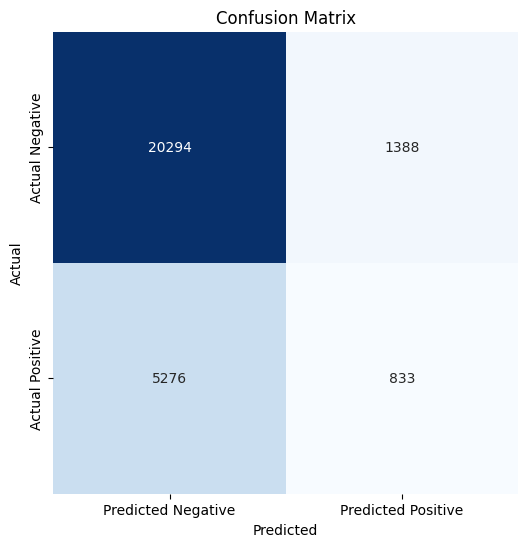

In [62]:
conf_matrix = [[20294,  1388],[ 5276,   833]]
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Balanceo de clases

Tras una primera aproximación vamos a balancear las clases y ver cuánto mejora el modelo

In [ ]:
import pandas as pd

# Dsitribución de clases inicial
y_train_df = pd.DataFrame(y_train, columns=['day_type'])
y_train_df["day_type"].value_counts()

day_type
0    83752
1    39981
Name: count, dtype: int64

Aplicamos oversampling con SMOTE sobre la clase minoritaria

In [ ]:
from imblearn.combine import SMOTEENN

X = df_train
y = y_train_df

# Se aplica SMOTENN para balancear las clases
smoteenn = SMOTEENN(sampling_strategy='auto', random_state=22)
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

In [ ]:
# Dsitribución de clases tras el oversampling
y_resampled["day_type"].value_counts()

day_type
1    83698
0    83624
Name: count, dtype: int64

Transformamos a arrays de NumPy

In [51]:
X_train_resampled = X_resampled.to_numpy()
y_train_resampled = y_resampled["day_type"].values

In [52]:
X_train.shape, X_test.shape

((123733, 93), (27791, 93))

### Definición del modelo

Reentrenamos el modelo. Ahora con clases balanceadas

In [53]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

# Definimos el modelo en NumPyro
def model(X, y=None):
    # Definir los parámetros del modelo (coeficientes de regresión)
    n_features = X.shape[1]  # Número de características (columnas en X)
    beta = numpyro.sample("beta", dist.Normal(jnp.zeros(n_features), jnp.ones(n_features))) # coeficientes
    intercept = numpyro.sample("intercept", dist.Normal(0., 1.))

    # Calcular la probabilidad de la clase positiva usando la regresión logística
    logits = intercept + jnp.dot(X, beta)  # Logit es la combinación lineal de las características
    p = dist.Bernoulli(logits=logits).probs

    # Si y es proporcionado, tenemos datos observacionales y calculamos la probabilidad
    with numpyro.plate("data", X.shape[0]):
        obs = numpyro.sample("obs", dist.Bernoulli(p), obs=y)

In [54]:
import jax
print(jax.devices())  # Verifica que esté usando la GPU

[CudaDevice(id=0)]


In [55]:
from numpyro.infer import MCMC, NUTS

# Definir el sampler NUTS (No-U-Turn Sampler)
nuts_kernel = NUTS(model)

# Configurar el MCMC con el número de iteraciones
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1)

# Ejecutar MCMC para el entrenamiento
mcmc.run(jax.random.PRNGKey(0), X_train_resampled, y_train_resampled)

# Obtener los resultados del muestreo
posterior_samples = mcmc.get_samples()

# Ver los coeficientes muestreados
posterior_samples["beta"], posterior_samples["intercept"]

sample: 100%|██████████| 1500/1500 [59:04<00:00,  2.36s/it, 1023 steps of size 2.21e-03. acc. prob=0.82] 


(Array([[-2.6274299e-02, -1.4186098e-02,  4.1454160e-03, ...,
         -2.9398046e+00, -3.2170014e+00, -1.1520959e+00],
        [-1.8645544e-02,  1.5005629e-03, -4.4032880e-03, ...,
         -2.8648958e+00, -3.1481440e+00, -3.2550275e-01],
        [-2.5215155e-02, -1.9473620e-02,  1.0227397e-03, ...,
         -2.9245226e+00, -3.2099547e+00,  5.6544369e-01],
        ...,
        [-1.7546903e-02, -1.7361516e-02,  2.2404357e-03, ...,
         -2.6198864e+00, -2.8982096e+00,  4.5396996e-01],
        [-1.9561835e-02, -2.3592992e-02, -4.7614346e-03, ...,
         -2.6514957e+00, -2.9277146e+00,  1.5366589e+00],
        [-2.2877607e-02, -1.2997262e-02, -3.9427527e-05, ...,
         -2.7451651e+00, -3.0151119e+00,  7.4304509e-01]], dtype=float32),
 Array([6.0254226, 6.0404806, 6.728822 , 6.4053683, 6.1096954, 5.699631 ,
        5.9315743, 6.0638385, 5.8548822, 5.942408 , 6.445832 , 6.426219 ,
        5.713491 , 5.8397446, 6.070563 , 5.394914 , 5.553447 , 5.4196343,
        5.3526793, 5.6170025

In [56]:
# Predicciones en el conjunto de test (promediando sobre las 1000 muestras)
logits_test = posterior_samples["intercept"].mean(axis=0) + jnp.dot(X_test, posterior_samples["beta"].mean(axis=0).T)

# Obtener probabilidades de clase (0 o 1) para cada observación
p_test = jax.nn.sigmoid(logits_test)

# Convertir probabilidades a clases (0 o 1)
y_pred = (p_test > 0.5).astype(int)

# Asegurarse de que y_test es un vector 1D
y_test = y_test.flatten()  # Esto también es importante si y_test es 2D

# Evaluar las predicciones
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6548


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# AUC-ROC
auc_roc = roc_auc_score(y_test, p_test)

# Imprimir resultados
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Reporte completo de clasificación
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Precision: 0.2922
Recall: 0.4010
F1 Score: 0.3381
AUC-ROC: 0.6189
Confusion Matrix:
[[15747  5935]
 [ 3659  2450]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     21682
           1       0.29      0.40      0.34      6109

    accuracy                           0.65     27791
   macro avg       0.55      0.56      0.55     27791
weighted avg       0.70      0.65      0.67     27791



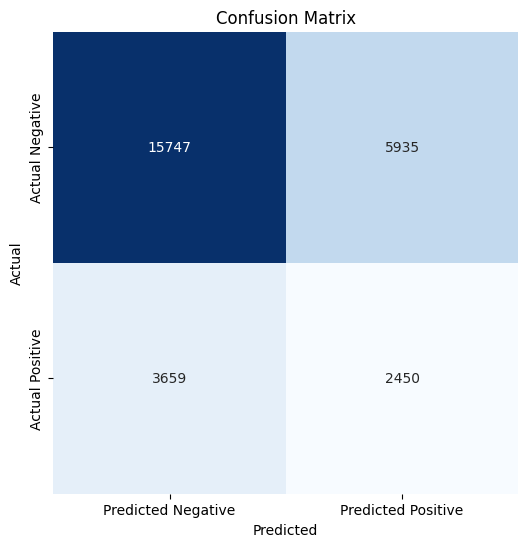

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar la matriz de confusión
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Las métricas generales mejoran pero aún así el modelo tiene dificultades para clasificar correctamente la clase positiva (fin de semana/festivo).

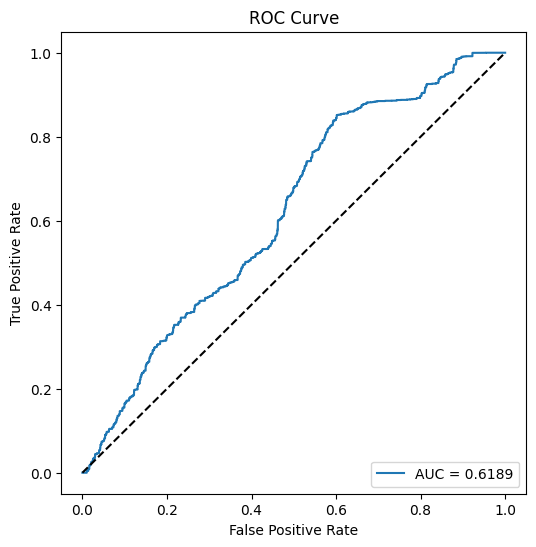

In [59]:
from sklearn.metrics import roc_curve

# Calcular las tasas de verdaderos positivos (TPR) y falsos positivos (FPR)
fpr, tpr, thresholds = roc_curve(y_test, p_test)

# Graficar la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal (sin discriminación)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


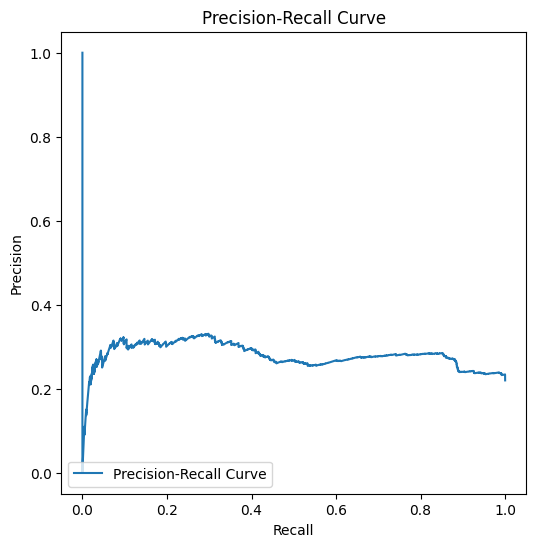

In [60]:
from sklearn.metrics import precision_recall_curve

# Calcular la precisión y el recall para diferentes umbrales
precision_vals, recall_vals, _ = precision_recall_curve(y_test, p_test)

# Graficar la curva Precision-Recall
plt.figure(figsize=(6, 6))
plt.plot(recall_vals, precision_vals, label=f'Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()
